<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/InsectSAM/InsectSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InsectSAM

In this notebook, we'll fine-tune `segment-anything` on a dataset of insect images and their corresponding masks for the RB-IBDM project.

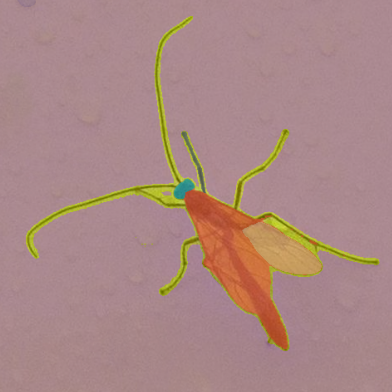

Resources used to create this notebook (thanks):

#### [Segment Anything](https://segment-anything.com/)
#### [Finetune SAM Blog](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
#### [MedSAM repository](https://github.com/bowang-lab/MedSAM)
#### [HF Forum](https://discuss.huggingface.co/)

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00


In [3]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.4 MB/s eta 0:00:00


## Load dataset

See [this guide](https://huggingface.co/docs/datasets/image_dataset) from Hugging Face.

In [4]:
from datasets import load_dataset

dataset = load_dataset("martintmv/rb-ibdm-l", split="train")

Generating train split:   0%|          | 0/733 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 733
})

We can visualize an example:

Format of the image: PNG


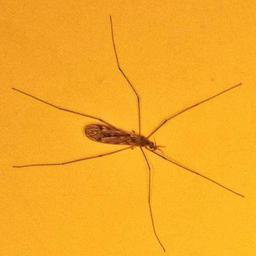

In [6]:
example = dataset[0]
image = example['image']

# Print the format of the image
print("Format of the image:", image.format)
image

Format of the image: TIFF


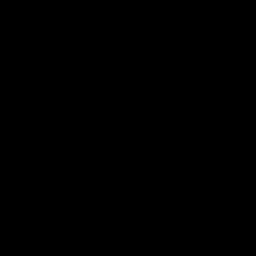

In [7]:
example = dataset[0]
label = example["label"]

# Print the format of the image
print("Format of the image:", label.format)
label

(-0.5, 255.5, 255.5, -0.5)

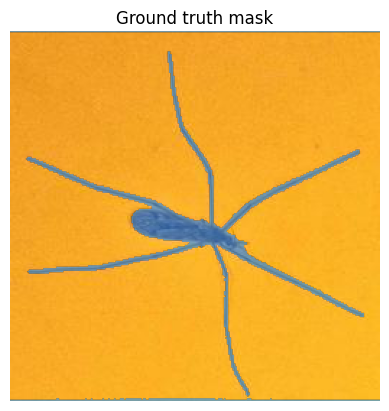

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [9]:
ground_truth_seg.shape

(256, 256)

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [10]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [11]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [13]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [14]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [17]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [18]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Train the model

In [19]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# num_epochs = 10
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 367/367 [03:39<00:00,  1.67it/s]


EPOCH: 0
Mean loss: 0.36732934863999367


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 1
Mean loss: 0.1661367205654243


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 2
Mean loss: 0.152208776814655


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 3
Mean loss: 0.1449510940231322


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 4
Mean loss: 0.1406639893145912


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 5
Mean loss: 0.13670600210735193


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 6
Mean loss: 0.13313830355613693


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 7
Mean loss: 0.13033555405422517


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 8
Mean loss: 0.12759614704374722


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 9
Mean loss: 0.12452277981699


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 10
Mean loss: 0.12332118976587171


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 11
Mean loss: 0.1191822125776912


100%|██████████| 367/367 [03:40<00:00,  1.66it/s]


EPOCH: 12
Mean loss: 0.11568406993670424


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 13
Mean loss: 0.11158464436878625


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 14
Mean loss: 0.1097295862351029


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 15
Mean loss: 0.10520483109825964


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 16
Mean loss: 0.10190735229516874


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 17
Mean loss: 0.09830473912549928


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 18
Mean loss: 0.09397526407660028


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 19
Mean loss: 0.09154971409842819


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 20
Mean loss: 0.08931742305042634


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 21
Mean loss: 0.08492453726216623


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 22
Mean loss: 0.08401997853324264


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 23
Mean loss: 0.08260766402069651


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 24
Mean loss: 0.08131561833827144


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 25
Mean loss: 0.07918679435567408


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 26
Mean loss: 0.07794596218283235


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 27
Mean loss: 0.07660770844617397


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 28
Mean loss: 0.07502981905675714


100%|██████████| 367/367 [03:43<00:00,  1.65it/s]


EPOCH: 29
Mean loss: 0.0730247725593053


100%|██████████| 367/367 [03:43<00:00,  1.64it/s]


EPOCH: 30
Mean loss: 0.07259405212481924


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 31
Mean loss: 0.07315638480702928


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 32
Mean loss: 0.07117796810064718


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 33
Mean loss: 0.06930712838872902


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 34
Mean loss: 0.07018262433644375


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 35
Mean loss: 0.0769707011794849


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 36
Mean loss: 0.0726167516026656


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 37
Mean loss: 0.06869616126007215


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 38
Mean loss: 0.06584727207366226


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 39
Mean loss: 0.06473718206740774


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 40
Mean loss: 0.06483854761484209


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 41
Mean loss: 0.0657339935528485


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 42
Mean loss: 0.06609654194632246


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 43
Mean loss: 0.06776754361671225


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 44
Mean loss: 0.06421640847253865


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 45
Mean loss: 0.06219624069440673


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 46
Mean loss: 0.06130711985777363


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 47
Mean loss: 0.06081416396987536


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 48
Mean loss: 0.06289596081652986


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 49
Mean loss: 0.06334848437021799


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 50
Mean loss: 0.060312734886354254


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 51
Mean loss: 0.0610842099464029


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 52
Mean loss: 0.06091970969651311


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 53
Mean loss: 0.05985820451776728


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 54
Mean loss: 0.059124499003654116


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 55
Mean loss: 0.05714653638427524


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 56
Mean loss: 0.05726015357153455


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 57
Mean loss: 0.05677475025293694


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 58
Mean loss: 0.056412016511044646


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 59
Mean loss: 0.06224268485540752


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 60
Mean loss: 0.0615033334430703


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 61
Mean loss: 0.06205009164070401


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 62
Mean loss: 0.05557713834238962


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 63
Mean loss: 0.053786251282862484


100%|██████████| 367/367 [03:42<00:00,  1.65it/s]


EPOCH: 64
Mean loss: 0.05335755952778564


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 65
Mean loss: 0.05311558601428686


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 66
Mean loss: 0.053362535089457395


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 67
Mean loss: 0.053548800193118466


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 68
Mean loss: 0.05369803461446668


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 69
Mean loss: 0.05559320691516192


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 70
Mean loss: 0.05261346574984389


100%|██████████| 367/367 [03:40<00:00,  1.66it/s]


EPOCH: 71
Mean loss: 0.052087443568604196


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 72
Mean loss: 0.05132213077566279


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 73
Mean loss: 0.05262775278373619


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 74
Mean loss: 0.05788356308350771


100%|██████████| 367/367 [03:40<00:00,  1.66it/s]


EPOCH: 75
Mean loss: 0.05265358561644843


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 76
Mean loss: 0.05027962800582277


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 77
Mean loss: 0.04928102160801436


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 78
Mean loss: 0.049215749294398106


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 79
Mean loss: 0.049810039478402374


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 80
Mean loss: 0.04954970482488135


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 81
Mean loss: 0.05010723034858866


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 82
Mean loss: 0.04934873352492132


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 83
Mean loss: 0.049785361983064734


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 84
Mean loss: 0.050031069874235654


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 85
Mean loss: 0.04908235410954143


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 86
Mean loss: 0.04779291566339517


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 87
Mean loss: 0.04777456573603994


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 88
Mean loss: 0.048286382903215505


100%|██████████| 367/367 [03:41<00:00,  1.65it/s]


EPOCH: 89
Mean loss: 0.046988866946657444


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 90
Mean loss: 0.04701453885850205


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 91
Mean loss: 0.04738627193236789


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 92
Mean loss: 0.04764056597564786


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 93
Mean loss: 0.046521465814284145


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 94
Mean loss: 0.047613886527575006


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 95
Mean loss: 0.047737355450579354


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 96
Mean loss: 0.04589248475763307


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 97
Mean loss: 0.045345064859116595


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]


EPOCH: 98
Mean loss: 0.04544181308178713


100%|██████████| 367/367 [03:41<00:00,  1.66it/s]

EPOCH: 99
Mean loss: 0.045566835247832845


In [21]:
import os
from google.colab import drive

drive.mount('/content/drive')

# save the model
model_save_path = '/content/drive/MyDrive/diopsis_tests/InsectSAM.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Mounted at /content/drive
Model saved to /content/drive/MyDrive/diopsis_tests/InsectSAM.pth


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

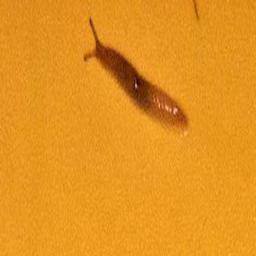

In [22]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 4

# load image
image = dataset[idx]["image"]
image

In [23]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [24]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [25]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

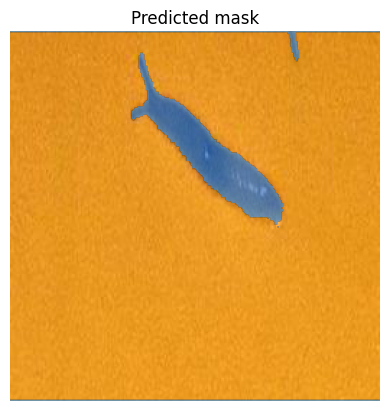

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

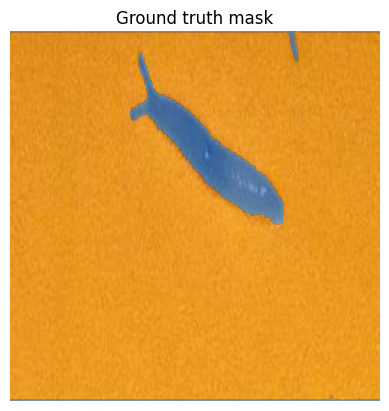

In [27]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")